## Adaptive RAG Agent with Langgraph
 - Follows ideas from 3 papers:

    1. Adaptive RAG - Route questions to different retrieval approaches.
    2. Corrective RAG - Fallback to web search if docs are not relevant to query.
    3. Self Correction in RAG - Fix answers w/ hallucinations or don't address question.

In [1]:
# ollama pull llama3.2:3b-instruct-fp16
# pip install langchain-nomic

In [2]:
# imports 
from langchain_ollama import ChatOllama
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
# schemas are all base interfaces of langchain
from langchain.schema import Document

from langgraph.graph import StateGraph
from langgraph.graph import END
from pydantic import BaseModel, Field
from typing import Literal, List, Annotated, TypedDict
import operator
import json


from dotenv import load_dotenv
load_dotenv("../secrets/local.env")

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [3]:
# schemas
class Grader(BaseModel):
    binary_score: Literal['yes', 'no'] = Field(description="The final grade / score assigned.")

class ReasoningGrader(BaseModel):
    binary_score: Literal['yes', 'no'] = Field(description="The final grade / score assigned.")
    explanation: str = Field(description="The step by step explanation of the final binary score.")

In [4]:
## LLM  
local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(name="llama", model=local_llm, request_timeout=120.0)
llm_json_mode = ChatOllama(name="llama", model=local_llm, request_timeout=120.0, json_mode=True)

In [5]:
llm.invoke("")

AIMessage(content="I'm not sure I understand what you're asking. Could you please provide more context or clarify your question? I'll do my best to help.", additional_kwargs={}, response_metadata={'model': 'llama3.2:3b-instruct-fp16', 'created_at': '2024-11-11T11:52:49.884110491Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 449733628, 'load_duration': 8787279, 'prompt_eval_count': 25, 'prompt_eval_duration': 23484000, 'eval_count': 31, 'eval_duration': 375595000}, id='run-a7d51a7a-a048-44a6-97bb-73654ca3e2f9-0', usage_metadata={'input_tokens': 25, 'output_tokens': 31, 'total_tokens': 56})

In [6]:
# data
urls = [
    "https://www.promptingguide.ai/introduction/tips/",
    "https://www.promptingguide.ai/techniques/cot/",
    "https://www.promptingguide.ai/techniques/meta-prompting/",
    "https://www.promptingguide.ai/techniques/prompt_chaining/",
    "https://agentprotocol.ai/protocol/",
    "https://agentprotocol.ai/",
]


# Load the documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(documents=docs_list)

# Add vectorDB
vector_store = FAISS.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")
)

In [7]:
# create retriever
rag_retriever = vector_store.as_retriever(k=3)

In [8]:
### Web search tool
web_search_tool = TavilySearchResults(k=3)

### Components

In [9]:
### Router

# Prompt
router_instructions =\
    "You are an expert at routing user questions to either a vectorstore or web search. "\
    "The vectorstore contains documents related to prompt engineering & agent protocol. "\
    "Use the vectorstore for questions related to those topics. For all else, especially for current events, use websearch. "\
    "Return JSON with single key, datasource, that is `websearch` or `vectorstore` depending on question."

# test router
test_vectorstore = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the types of prompting?")]
)


test_websearch = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="How is the stock market doing ?")]
)

print(json.loads(test_vectorstore.content), json.loads(test_websearch.content))

{'datasource': 'vectorstore'} {'datasource': 'websearch'}


In [10]:
### Document grader

# instructions
doc_grader_instructions = """
    You are a grader assessing the relevance of a retrieved document to user question.
    If document contains keyword(s) or semantic information relevant to a given question, grade it as relevant.
"""

# Grader prompt
doc_grader_prompt = """
    Here is the retrieved document:

    {document}

    Here is the user question:

    {question}.
    Carefully and objectively assess whether the document contains at least some amount of relevant information about the asked question.
    Return JSON with a single key, binary_score, that is 'yes' or 'no' score."""

# Test
question = "What is Agent protocol"
docs =  rag_retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.with_structured_output(Grader).invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
# json.loads(result.content.strip('```'))

In [11]:
### Generate

# Prompt
rag_prompt = """
    You are an assistant for question-answering tasks.

    Here is the context to use to answer the question.

    {context}

    Think carefully about the above context.

    Now, review the user question.

    {question}

    Provide an answer to this question using only the above context.

    Use three sentences at maximum to keep the answer concise.

    Answer:"""

# post processing
def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)


# Test
docs = rag_retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)

generation = llm.invoke([SystemMessage(content=rag_prompt)] + [HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

The Agent Protocol is a process used in Zero-Shot-CoT (ZSCoT) that involves two stages: question clustering and demonstration sampling. In Stage 1, questions are clustered into a few groups based on their characteristics such as length and number of steps in the rationale. This is done to select representative questions from each cluster for further generation of reasoning chains using simple heuristics.


In [12]:
### Generate

# Prompt
rag_prompt = """
    You are an assistant for question-answering tasks.

    Here is the context to use to answer the question.

    {context}

    Think carefully about the above context.

    Now, review the user question.

    {question}

    Provide an answer to this question using only the above context.

    Use three sentences at maximum to keep the answer concise.

    Answer:"""

# post processing
def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)


# Test
docs = rag_retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)

generation = llm.invoke([SystemMessage(content=rag_prompt)] + [HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Agent Protocol is a process described in Zhang et al. (2022) that involves two stages: question clustering and demonstration sampling. In Stage 1, questions are partitioned into clusters based on certain criteria such as question length or number of steps in rationale. Stage 2 involves selecting representative questions from each cluster and generating their reasoning chains using Zero-Shot-CoT with simple heuristics.


In [13]:
### Generate

# Prompt
rag_prompt = """
    You are an assistant for question-answering tasks.

    Here is the context to use to answer the question.

    {context}

    Think carefully about the above context.

    Now, review the user question.

    {question}

    Provide an answer to this question using only the above context.

    Use three sentences at maximum to keep the answer concise.

    Answer:"""

# post processing
def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)


# Test
docs = rag_retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)

generation = llm.invoke([SystemMessage(content=rag_prompt)] + [HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Agent Protocol is a process that involves two stages: 

1. Question clustering: partitioning questions into clusters, and 
2. Demonstration sampling: selecting representative questions from each cluster and generating their reasoning chains using Zero-Shot-CoT with simple heuristics such as length of questions and number of steps in rationale.

This protocol aims to encourage the model to use simple and accurate demonstrations, ultimately improving the quality of generated responses.


In [14]:
### Hallucination Grader

# Hallucination Grader instructions
hallucination_instructions = """
    You are a teacher grading a college test.
    You will be given FACTS and a STUDENT_ANSWER.
    Here is the criteria for grading:

    (1) Ensure the STUDENT_ANSWER is grounded in the FACTS.
    (2) Ensure the STUDENT_ANSWER does not contain **hallucinated** information outside of the FACTS.

    Score: 
    A score of yes means that the student's answers meets all the above criteria. This is the highest(best) score.
    A score of no means that the student's answer does not meet all the criteria. This is the lowest possible score.

    Explain your reasoning in step-by-step fashion to ensure your reasoning and conclusion are correct."""

# Prompt
hallucination_grader_prompt = """
    FACTS: \n\n {facts} \n\n STUDENT_ANSWER: \n\n {generation}.
    Return JSON with two keys, binary_score, 'yes' or 'no' to indicate whether the STUDENT_ANSWER is grounded in facts. And a key explanation, that contains an explanation of the score."""

# Test using documents and generation from above.
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(facts=docs_txt, generation=generation)

result = llm_json_mode.with_structured_output(ReasoningGrader).invoke(
    [SystemMessage(content=hallucination_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)

result

In [15]:
### Answer Grader

# answer grader instructions
answer_grader_instructions = """You are a teacher grading a test.
    You will be given a QUESTION and a STUDENT_ANSWER.
    Here is the criteria to follow:

    (1) The STUDENT_ANSWER helps to answer the QUESTION accurately.

    Score:
    A score of 'yes' means  that the student's answer meets all of the criteria. This is the highest (best) score.
    The student can receive a score of yes if the answer  contains extra information that is not explicitly asked for in the question.

    A score of 'no' means  that the student's answer does not meet all of the criteria. This is the lowest possible score.

    Explain in a step by step fashion to ensure your reasoning and conclusion are correct.
    Avoid simply answering the correct answer right away."""

# Grader prompt
answer_grader_prompt = """QUESTION:

{question}

STUDENT_ANSWER: 

{generation}
Return JSON with two keys, binary_score is 'yes' or 'no' dependent on whether the criteria is followed. And a key explaination, containing the step-by-step explaination for the answer.
"""

# Test
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question, generation=generation
)


result = llm_json_mode.with_structured_output(ReasoningGrader).invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)

result

ReasoningGrader(binary_score='yes', explanation='The student answer accurately describes the Agent protocol as a two-stage process: question clustering and demonstration sampling. The explanation provided by the model describes how this protocol aims to encourage models to use simple and accurate demonstrations, ultimately improving response quality.')

### Graph

In [16]:
### Using langgraph to construct the flow of adaptive RAG

class AdaptiveRAGState(TypedDict):
    question: str 
    generation: str
    web_search: str
    max_retries: int
    answers: int
    loop_step: Annotated[int, operator.add]
    documents: List[str]   # list of retrieved documents

In [17]:
### Define Nodes
# Nodes are nothing but sync or async functions that take in the state and modify it or generate things based on it.

def retriever(state: AdaptiveRAGState):
    print("** RETRIEVE **")
    question = state['question']

    # Write retrieved documents to documents in key state
    documents = rag_retriever.invoke(question)
    return {'documents': documents}


def generate(state):
    print("** GENERATE **")
    question = state['question']
    loop_step = state.get('loop_step', 0)  # start with zero loop
    documents = state['documents']

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    
    return {'generation': generation, 'loop_step': loop_step + 1}


def grade_documents(state):
    print("** CHECK DOCUMENT RELEVANCE **")

    question = state['question']
    documents = state['documents']

    # score each doc
    filtered_docs = []
    websearch = "no"
    for doc in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=doc.page_content, question=question)
        result = llm_json_mode.with_structured_output(Grader).invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])

        grade = result.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("** GRADE: DOCUMENT RELEVANT **")
            filtered_docs.append(doc)
        
        else:
            print("** GRADE: DOCUMENT IRRELEVANT")
            websearch = 'yes'
            continue
        
        return {'documents': filtered_docs, 'web_search': websearch}


def web_search(state):

    question = state['question']
    documents = state.get('documents', [])

    print("** WEB SEARCH **")

    docs = web_search_tool.invoke({'query': question})
    web_results = "\n".join([doc['content'] for doc in docs])
    web_results = Document(page_content=web_results)

    documents.append(web_results)

    return {
        'documents': documents
    }


## Edges

def route_question(state):
    print("** ROUTE QUESTION **")
    route_question = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state['question'])])

    source = json.loads(route_question.content)['datasource']

    print(source)

    if source == 'websearch':
        print("** ROUTING TO: websearch **")
        return 'websearch'
    elif source == "vectorstore":
        print("** ROUTING TO: retriever **")
        return 'vectorstore'


def decide_to_generate(state):
    print("** ASSESS GRADED DOCUMENTS **")

    question = state['question']
    filtered_documents = state['documents']
    websearch = state['web_search']

    if websearch == "yes":
        # All documents have been filtered 
        print("** DECISION: NOT ALL DOCUMENTS ARE RELEVANT")
        return 'websearch'
    
    else:
        # All the documents are relevant
        print("** DECISION: GENERATE **")
        return 'generate'


def grade_generation_w_documents_and_question(state):

    print("** CHECK FOR HALLUCINATIONS **")
    question = state['question']
    documents = state['documents']
    generation = state['generation']
    max_retries = state.get('max_retries', 3)  # keep default retries to 3 if not specified

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(facts=format_docs(documents), generation=generation)
    result = llm_json_mode.with_structured_output(ReasoningGrader).invoke([SystemMessage(content=hallucination_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    grade = result.binary_score

    if grade == 'yes':
        print("** DECISION: THE ANSWER IS GROUNDED IN DOCUMENTS**")
        # Check the answer relevance in question
        answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation)

        answer_grade = llm_json_mode.with_structured_output(ReasoningGrader).invoke([SystemMessage(content=answer_grader_instructions), HumanMessage(content=answer_grader_prompt_formatted)])

        if answer_grade.binary_score == 'yes':
            # The answer is relevant in the question
            return 'useful'
        elif state['loop_step'] <= max_retries:
            # The answer is not useful but we can retry
            return 'not useful'
        else:
            # the answer is not useful and we can't retry
            return 'max_retries'
    
    elif state['loop_step'] <= max_retries:
        # the answer is not relevant to the context but we can retry
        return 'not supported'
    
    else:
        return 'max_retries'


In [18]:
### Construct the graph

graph = StateGraph(AdaptiveRAGState)

# define the nodes
graph.add_node("websearch", web_search)
graph.add_node("retriever", retriever)
graph.add_node("grade_documents", grade_documents)
graph.add_node("generate", generate)

# define the edges and conditional edges

graph.set_conditional_entry_point(route_question, {'websearch': 'websearch', 'vectorstore': 'retriever'})
graph.add_edge('websearch', 'generate')
graph.add_edge('retriever', 'grade_documents')
graph.add_conditional_edges("grade_documents", decide_to_generate, {'websearch': "websearch", "generate": "generate"})
graph.add_conditional_edges("generate", grade_generation_w_documents_and_question, {"not supported": "generate", "useful": END, "not useful": "websearch", "max_retries": END})


# compile
adaptive_rag = graph.compile()

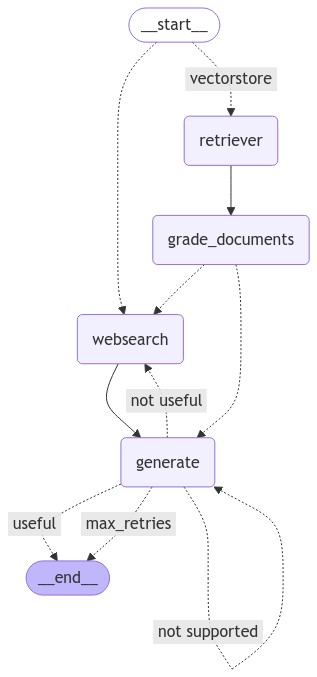

In [19]:
from IPython.display import Image, display

display(Image(adaptive_rag.get_graph().draw_mermaid_png()))

In [20]:
## TEST
inputs = {"question": "What are the features of the newly released Llama3.2 models?", "max_retries": 3}
for event in adaptive_rag.stream(inputs, stream_mode="values"):
    print(event)

** ROUTE QUESTION **
websearch
** ROUTING TO: websearch **
{'question': 'What are the features of the newly released Llama3.2 models?', 'max_retries': 3, 'loop_step': 0}
** WEB SEARCH **
{'question': 'What are the features of the newly released Llama3.2 models?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Llama 3.2 is Meta’s first open-source AI model capable of processing both text and images. Llama 3.2 1B and 3B Model Performance. Llama 3.2 introduces multimodal models (11B and 90B) that can process both text and images. Llama 3.2 incorporates a new adapter architecture for vision models, integrating image encoder representations. As the first Llama models capable of handling vision tasks, the 11B and 90B models required a new architecture designed to support image reasoning. The team applied two techniques — pruning and distillation — to the 1B and 3B models, making them the first highly capable, lightweight Llama models that can efficiently 